# Tutorial 4 - Linear operators

In this tutorial, we consider the implementation of linear operators within the ```pygeoinf``` library through the ```LinearOperator``` class. 

### Defining a linear operator

Let $X$ and $Y$ be two Hilbert spaces represented by ```HilbertSpace``` objects. A linear operator between them is specified through its mapping. This is shown in the following example using instances of ```EuclideanSpace``` as the domain and codomain of the mapping. 

In [1]:
import numpy as np
from pygeoinf import EuclideanSpace, LinearOperator

# Set the domain of the operator. 
X = EuclideanSpace(5)

# Set the codomain of the operator. 
Y = EuclideanSpace(3)

# Define the linear operator as a projection from X to Y. 
A = LinearOperator(X, Y, lambda x : x[:Y.dim])

Having defined the operator, we can compute its action on vectors as follows:

In [2]:
x = X.random()
print(f'The vector x is:  {x}')

y = A(x)
print(f'The vector Ax is: {y}')

The vector x is:  [-0.28975226 -0.57456512  0.70859188 -0.26995074  0.08562781]
The vector Ax is: [-0.28975226 -0.57456512  0.70859188]


Linear operators can be combined in the usual manners so long as their domains and codomains are compatible. For example:

In [3]:
# Project the final elements onto Y. 
B = LinearOperator(X, Y, lambda x : x[-Y.dim:])

x = X.random()
print(f'The vector x is:       {x}')

y = A(x)
print(f'The vector y = Ax is:  {y}')

w = B(x)
print(f'The vector w = Bx is:  {w}')

C = A + 2 * B
z = C(x)
print(f'The vector (A+2B)x is: {z}')
print(f'The vector y+2w is:    {y+2*w}')

# Inclusion of Y into X. 
D = LinearOperator(Y, X, lambda y : np.concatenate([y, np.zeros(X.dim-Y.dim)]))

E = D @ A
print(f'The vector (DA)(x) is: {E(x)}')

The vector x is:       [-0.28795673  0.73365186 -0.14921437 -0.43172445 -0.32080789]
The vector y = Ax is:  [-0.28795673  0.73365186 -0.14921437]
The vector w = Bx is:  [-0.14921437 -0.43172445 -0.32080789]
The vector (A+2B)x is: [-0.58638547 -0.12979705 -0.79083015]
The vector y+2w is:    [-0.58638547 -0.12979705 -0.79083015]
The vector (DA)(x) is: [-0.28795673  0.73365186 -0.14921437  0.          0.        ]


Algebraic combinations of such operators are always detemrined lazily, and hence there is essentially no cost until their action is computed. 



### Dual operators

For a linear operator, $A \in \mathrm{Hom}(X,Y)$, the corresponding **dual operator**, $A' \in \mathrm{Hom}(Y',X')$ is defined through
$$
\langle y', Ax \rangle = \langle A'y', x \rangle, 
$$
for all $x \in X$ and $y' \in Y'$. Such an operator can be accessed from a ```LinearOperator``` using its ```dual``` property. This is shown in the code below where we verify that the defining identity holds. 

In [4]:
x = X.random()
yp = Y.dual.random()

print(f'<yp, Ax>    = {yp(A(x))}')
print(f'<Ap(yp), x> = {A.dual(yp)(x)}')

<yp, Ax>    = -0.5140526363834335
<Ap(yp), x> = -0.5140526363834335


Here we see that once a ```LinearOperator``` has been defined its dual is automatically available. This is done internally using the defining relation for the dual operator. However, this implementation is inefficient and should be used rarely. Indeed, the action of of this dual operator on a vector of dimension $n$ requires $n$ actions of the original operator to be computed. Rather, went constructing a ```LinearOperator``` the dual mapping can be provided directly as a key-word argument. 

Consider the projection operator, $A$, defined above. In this case we see that 
$$
\langle y', Ax \rangle = \sum_{i=1}^{m} y'_{i} x_{i}, 
$$
where $m = \dim Y$. It follows that $A'y'$ is the dual vector in $X'$ whose first $m$ components equal those of $y'$
while all others are zero. Using this result, we can re-implement the projection operator as follows:


In [5]:
# Define the mapping and the dual mapping
def mapping(x):
    return x[:Y.dim]

def dual_mapping(yp):
    cyp = Y.dual.to_components(yp)
    cxp = np.concatenate([cyp, np.zeros(X.dim-Y.dim)])
    return X.dual.from_components(cxp)

# Construct the operator. 
A = LinearOperator(X, Y, mapping, dual_mapping=dual_mapping)

# Check that it performs as required. 
x = X.random()
yp = Y.dual.random()

print(f'<yp, Ax>    = {yp(A(x))}')
print(f'<Ap(yp), x> = {A.dual(yp)(x)}')


<yp, Ax>    = 0.42474634545634204
<Ap(yp), x> = 0.42474634545634204


### Adjoint operators

For $A \in \mathrm{Hom}(X,Y)$ we can also define its **adjoint operator**, $A^{*} \in \mathrm{Hom}(Y, X)$, through
$$
(y, Ax)_{Y} = (A^{*}y, x)_{X}, 
$$
for all $x \in X$ and $y \in Y$. For a ```LinearOperator``` the adjoint can be accessed through its ```adjoint``` property:

In [6]:
# Define the projection again just in terms of its mapping. 
A = LinearOperator(X, Y, mapping)

x = X.random()
y = Y.random()

print(f'(y,Ax) = {Y.inner_product(y, A(x))}')
print(f'(A*y,x) = {Y.inner_product(A.adjoint(y), x)}')

(y,Ax) = 0.4998519953512728
(A*y,x) = 0.4998519953512728


The dual and adjoint operators are related, and in the above case this relation is used to determine the adjoint from the automatically generated dual. Recalling the Riesz representation theorem in terms of an isometric isomorphisms $J_{X} = \mathrm{Hom}(X',X)$ and
$J_{Y} = \mathrm{Hom}(Y',Y)$, it is readily seen that 
$$
A^{*} = J_{X} A' J_{Y}^{-1}.
$$

If a ```LinearOperator``` is constructed given an explicit dual mapping, then the above relation is used to efficiently implement its adjoint. Equally, an ```adjoint_mapping``` can be provided as a key-word argument, and then the above relation generates the dual mapping. 

In the case of the projection, $A$, from $X$ to $Y$, a simple calculation shows that $A^{*}$ is just the inclusion from $Y$ into $X$. We can, therefore, implement this operator as follows:

In [7]:
def adjoint_mapping(y):
    return np.concatenate([y, np.zeros(X.dim-Y.dim)])

A = LinearOperator(X, Y, mapping, adjoint_mapping=adjoint_mapping)

# Test the adjoint
x = X.random()
y = Y.random()
print(f'(y,Ax) = {Y.inner_product(y, A(x))}')
print(f'(A*y,x) = {Y.inner_product(A.adjoint(y), x)}')

# Test the dual
yp = Y.dual.random()
print(f'<yp, Ax>    = {yp(A(x))}')
print(f'<Ap(yp), x> = {A.dual(yp)(x)}')

(y,Ax) = 1.7842834033108008
(A*y,x) = 1.7842834033108008
<yp, Ax>    = 2.654451647298774
<Ap(yp), x> = 2.654451647298774


As a general rule, wheneven a ```LinearOperator``` is constructed, **either its dual or its adjoint mapping should be explicitly provided**. 


### Matrix representations

If $X$ is modeled by a ```HilbertSpace```, recall that we have mappings $P_{X} \in \mathrm{Hom}(X, \mathbb{R}^{n})$ and 
$I_{X} \in \mathrm{Hom}(\mathbb{R}^{n},X)$ that, respectively, map vectors to and from their components. Given a linear operator, 
$A \in \mathrm{Hom}(X,Y)$ we can then define its **matrix representation** by
$$
\hat{A} = P_{Y} A I_{X} \in \mathrm{Hom(\mathbb{R}^{n}, \mathbb{R}^{m})}. 
$$ 
This operator can be viewed as an $m\times n$ matrix, and from a ```LinearOperator``` it can be accessed as follows:

In [8]:
Ah = A.matrix(dense=True)
print(Ah)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


Note the inclusion of the key-word argument ```dense``` when using the ```matrix``` method. Without this, the default is to return the matrix representation as a ```scipy``` ```LinearOperator``` instance. This latter option is useful when interfacing between ```pygeoinf``` operators and numerical algorithms provided by ```scipy```. 

The dense matrix representation is generated by successively acting the operator on the image of the standard Euclidean basis vectors. A ```LinearOperator``` can also be printed, the result just being its dense matrix representation:

In [9]:
print(A)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


If the matrix representation of an linear operator is available, this can be used to generate the correspondind ```LinearOperator``` using the ```from_matrix``` static method. This matrix is used internally to define the action of the operator, its dual, and its adjoint in an efficient manner. The matrix used can either be a dense ```numpy``` matrix or a ```scipy``` ```LinearOperator```. As an example, we can reconstruct our projection operator using its dense matrix representation: 

In [10]:
A = LinearOperator.from_matrix(X, Y, Ah)
print(A)

# Test the adjoint
x = X.random()
y = Y.random()
print(f'(y,Ax) = {Y.inner_product(y, A(x))}')
print(f'(A*y,x) = {Y.inner_product(A.adjoint(y), x)}')

# Test the dual
yp = Y.dual.random()
print(f'<yp, Ax>    = {yp(A(x))}')
print(f'<Ap(yp), x> = {A.dual(yp)(x)}')

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
(y,Ax) = 0.569604008988349
(A*y,x) = 0.569604008988349
<yp, Ax>    = 0.10551025899413669
<Ap(yp), x> = 0.10551025899413669


### Galerkin matrix representation

On a Hilbert space, a second useful matrix representation of a linear operator is available. Let $A\in \mathrm{Hom}(X,Y)$ 
and $\{e_{j}\}$ and $\{f_{i}\}$ be bases for $X$ and $Y$, respectively. The **Galerkin matrix representation** is the 
linear operator, $\tilde{A} \in \mathrm{Hom}(\mathbb{R}^{n}, \mathbb{R}^{m})$, with components
$$
\tilde{A}_{ij} = (f_{i}, A e_{j})_{Y}. 
$$
Equivalently, we can express this matrix as
$$
\tilde{A} = P_{Y'}J_{Y}^{-1}A I_{X}.
$$

From a ```LinearOperator``` its Galerkin matrix representation can be accessed from the ```matrix``` method using the key-word argument ```galerkin```:

In [11]:
Ag = A.matrix(dense=True, galerkin=True)
print(Ag)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In this example, the two matrix representations coincide because the mapping from Euclidean space to its dual is trivial. This is not the case in more general Hilbert spaces, however. The ```from_matrix``` method can also use Galerking representations to construct a ```LinearOperator```:

In [12]:
A = LinearOperator.from_matrix(X, Y, Ag, galerkin=True)
print(A)

# Test the adjoint
x = X.random()
y = Y.random()
print(f'(y,Ax) = {Y.inner_product(y, A(x))}')
print(f'(A*y,x) = {Y.inner_product(A.adjoint(y), x)}')

# Test the dual
yp = Y.dual.random()
print(f'<yp, Ax>    = {yp(A(x))}')
print(f'<Ap(yp), x> = {A.dual(yp)(x)}')

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
(y,Ax) = -2.0265670784115875
(A*y,x) = -2.0265670784115875
<yp, Ax>    = 0.8109249250063615
<Ap(yp), x> = 0.8109249250063615


### Self-dual and self-adjoint operators

A linear operator $A \in \mathrm{Hom}(X, X')$ is said to be **self-dual** if $A' = A$. Similarly, an operator
$A \in \mathrm{Hom}(X) = \mathrm{Hom}(X,X)$ is self-adjoint if $A^{*} = A$. The following results hold:

- The matrix representation of a self-dual operator is always symmetric.
- The Galerkin matrix representation of a self-adjoint operator is always symmetric.

These results follow readily from the definitions above along with the identities:
$$
I_{X}' = J_{\mathbb{R}^{n}}^{-1}P_{X'}, \quad P_{X}' = I_{X'}J_{\mathbb{R}^{n}}.
$$

The property for self-adjoint operators is important in practice. This is because various methods that use matrix representations depend upon the matrices being symmetrix (e.g., Cholesky decompositions), and hence it is the Galerking representation that should be used. 

If an operator is known to be self-dual or self-adjoint, then its construction can be simplified using the static methods ```self_dual``` and ```self_adjoint```, respectively which only require the operators domain and mapping to be provided. 

### Formal adjoints

In addition to duals and adjoint, the further concept of a formal adjoint is often of use when considering function spaces. Consider, for example, the Sobolev space $H^{s}(\mathbb{S}^{1})$ discussed in earlier tutorials. The derivative mapping:
$$
A u = \frac{\mathrm{d}u}{\mathrm{d}\theta},
$$
is continuous from $H^{s}(\mathbb{S}^{1})$ to $H^{s-1}(\mathbb{S}^{1})$. Determining the adjoint of this operator is possible, but it is complicated by the need to consider the inner products on the two spaces. Instead, it is easier to first compute its **formal adjoint**, $A^{\dagger}$, this being the adjoint defined relative to the $L^{2}(\mathbb{S}^{1})$ inner product and using smooth functions. It follows that 
for smooth $u$ and $v$ we have
$$
\int_{0}^{2\pi} (A^{\dagger}v) u \,\mathrm{d} \theta = \int_{0}^{2\pi} v \frac{\mathrm{d}u}{\mathrm{d}\theta} \,\mathrm{d} \theta
= -\int_{0}^{2\pi}  \frac{\mathrm{d}v}{\mathrm{d}\theta} u \,\mathrm{d} \theta, 
$$
and hence the formal adjoint is $A^{\dagger} = -A$. From the formal adjoint the dual operator can be constructed, and hence the adjoint also. This is all done within the static methods ```from_formal_adjoint``` and ```formally_self_adjoint```, with the latter applicable in cases that the operator is equal to its formal adjoint. 

To implement these ideas in practice, we can use the Fourier expansions that underlie our implementation of $H^{s}(\mathbf{S}^{1})$. Recall that each element of this space takes the form
$$
u = \sum_{k=\infty}^{\infty} u_{k} \phi_{k}, 
$$
with basis functions defined by 
$$
\phi_{k}(\theta) = \frac{1}{\sqrt{2\pi}} \mathrm{e}^{\mathrm{i} k \theta}
$$
It follows that 
$$
\frac{\mathrm{d}u}{\mathrm{d}\theta} = \sum_{k=\infty}^{\infty} \mathrm{i} k u_{k} \phi_{k}, 
$$
and hence in terms of Fourier coefficients differentiation us just a wave-number dependent scaling. Such a mapping is implemented below, and then we construct the ```LinearOperator``` using ```from_formal_adjoint```. In doing this, we make use of the methods ```to_coefficient``` and ```from_coefficient``` that return a real functions Fourier coefficients for non-negative wavenumbers. 


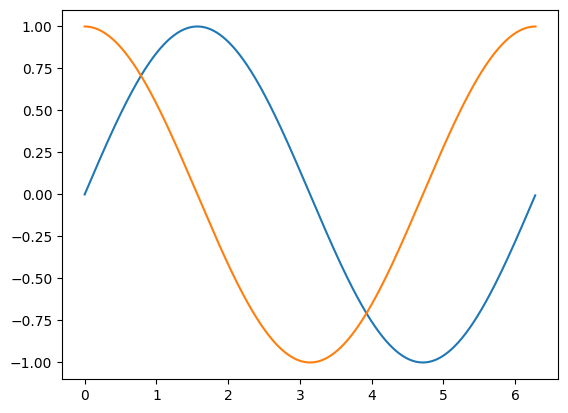

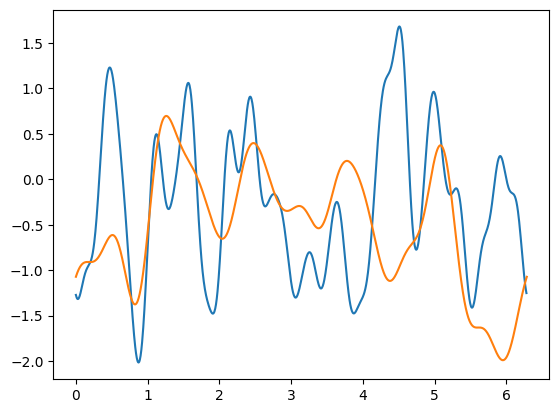

(v,Au) =  -18.286468062244953
(A*v,u) = -18.286468062244953


In [36]:
import matplotlib.pyplot as plt
from pygeoinf.homogeneous_space.circle import Sobolev


# Set up the spaces. Note the length scales can vary between the two. 
exponent = 2
length_scale_1 = 0.1
length_scale_2 = 0.3
X = Sobolev.from_sobolev_parameters(exponent,length_scale_1)
Y = Sobolev.from_sobolev_parameters(exponent-1,length_scale_2)

# Define the derivative mapping
def mapping(u):
    coeff = X.to_coefficient(u)
    for k in range(coeff.size):
        coeff[k] *= 1j * k
    return Y.from_coefficient(coeff)

def formal_adjoint(v):
    coeff = Y.to_coefficient(v)
    for k in range(coeff.size):
        coeff[k] *= -1j * k
    return X.from_coefficient(coeff)

    
# Set up the operator. 
A = LinearOperator.from_formal_adjoint(X, Y, mapping, formal_adjoint)

# Define a function on the domain
u = X.project_function(lambda th : np.sin(th))
v = A(u)

fig, ax = plt.subplots()
X.plot(u, fig=fig, ax=ax)
Y.plot(v, fig=fig, ax=ax)
plt.show()

# Check the adjoint identity using random functions. 
mu = X.heat_gaussian_measure(0.1, 1)
nu = Y.heat_gaussian_measure(0.2,1)

u = mu.sample()
v = nu.sample()

fig, ax = plt.subplots()
X.plot(u, fig=fig, ax=ax)
Y.plot(v, fig=fig, ax=ax)
plt.show()

print(f'(v,Au) =  {Y.inner_product(v, A(u))}')
print(f'(A*v,u) = {X.inner_product(A.adjoint(v), u)}')
